In [11]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
import os
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.constants import c
c= c*1e-3 #in km/s
import os
import random
from scipy.optimize import curve_fit

# MgII doublet values
from linetools.lists.linelist import LineList
linelist = LineList('ISM', verbose=False)
line1 = linelist['MgII 2796']
mg1 = line1['wrest'].value
line2 = linelist['MgII 2803']
mg2 = line2['wrest'].value
print(f"Mg_II first doublet = {mg1}\n" f"Mg_II second doublet = {mg2}\n" f"speed of light in vacuum in km/s = {c}")

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Mg_II first doublet = 2796.3543
Mg_II second doublet = 2803.5315
speed of light in vacuum in km/s = 299792.458


Fitted parameters: a = 3.08, b = -0.35


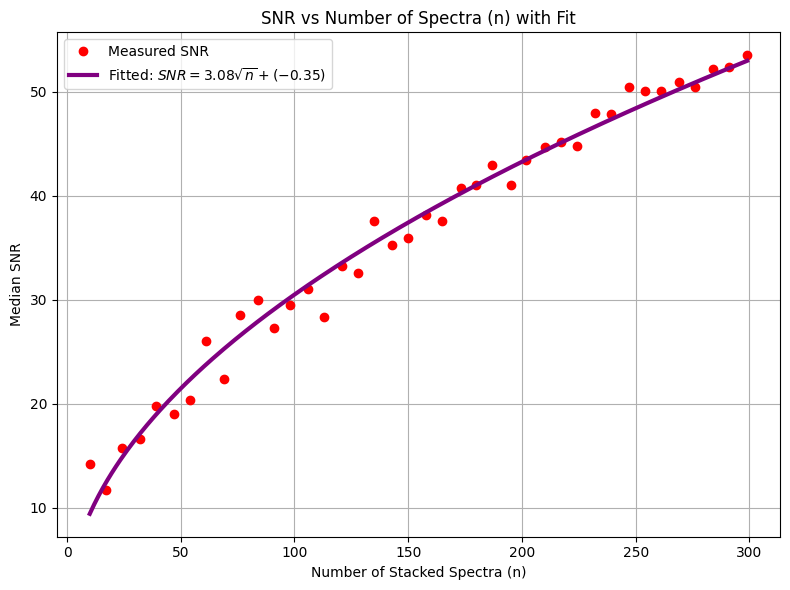

In [23]:
interpolated_dir = "/home/mehak/mehak/project/UDF_HUDF_sources_FULL /bg_sources/wave/interpolated_output7/"
text_file_dir = "/home/mehak/mehak/project/UDF_HUDF_sources_FULL /bg_sources/wave/snr_vs_n/"
pic_dir = "/home/mehak/mehak/project/report/pics/wave/snr_vs_n/"
interpolated_files = [f for f in os.listdir(interpolated_dir) if f.endswith(".txt")]
total_files = len(interpolated_files)

if total_files < 10:
    print("Not enough files to generate SNR vs n")
    exit()

# Create 40 linearly spaced values from 10 to total_files n
n_values = np.linspace(10, total_files, 40, dtype=int)
n_values = np.unique(n_values)  # ensure unique values

snr_list = []

for n in n_values:
    # Randomly sample n files
    selected_files = random.sample(interpolated_files, n)
    
    flux_list = []
    error_list = []

    for file in selected_files:
        file_path = os.path.join(interpolated_dir, file)
        try:
            data = np.loadtxt(file_path, skiprows=1)
            flux_list.append(data[:, 1])
            error_list.append(data[:, 2])
        except Exception as e:
            print(f"Skipping {file} due to error: {e}")
            continue

    # Convert to arrays
    flux_array = np.array(flux_list)
    error_array = np.array(error_list)

    if flux_array.shape[0] == 0:
        continue

    # Load wavelength from the first file
    wavelength = np.loadtxt(os.path.join(interpolated_dir, selected_files[0]), skiprows=1)[:, 0]

    # Stack using median
    stacked_flux = np.nanmedian(flux_array, axis=0)
    stacked_error = 1.253 * np.nanmedian(error_array, axis=0) / np.sqrt(len(selected_files))

    # Compute SNR in given windows
    snr_window1 = (wavelength >= 2780) & (wavelength <= 2790)
    snr_window2 = (wavelength >= 2809) & (wavelength <= 2819)

    snr_vals = np.concatenate([
        stacked_flux[snr_window1] / stacked_error[snr_window1],
        stacked_flux[snr_window2] / stacked_error[snr_window2]
    ])
    median_snr = np.nanmedian(snr_vals)
    snr_list.append(median_snr)

    # Plot the stacked spectrum
    plt.figure(figsize=(10, 6))
    plt.step(wavelength, stacked_flux, 'b-', label="Stacked Flux", lw=1.5)
    plt.fill_between(wavelength, stacked_flux - stacked_error, stacked_flux + stacked_error, color='blue', alpha=0.3, label="Error")
    plt.axvline(x=2796, color='green', lw=1.5, linestyle="--", label="2796 Å Mg II")
    plt.axvline(x=2803, color='green', lw=1.5, linestyle="--", label="2803 Å Mg II")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Stacked Flux")
    plt.xlim(2750, 2850)
    plt.title(f"Stacked Spectrum for n={n} (Median SNR = {median_snr:.2f})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(pic_dir, f"stacked_spectrum_n{n}.png"))
    plt.close()
    
#######################################################################################
## FITTING AND PLOTING THE SNR VS N DATA

# model function
def snr_ideal(n, a, b):
    return a * np.sqrt(n) + b

# Fitting the model to the data
n_fit = n_values[:len(snr_list)]  # in case some n were skipped due to errors
snr_fit = np.array(snr_list)

# curve fitting
params, covariance = curve_fit(snr_ideal, n_fit, snr_fit)
a_fit, b_fit = params
print(f"Fitted parameters: a = {a_fit:.2f}, b = {b_fit:.2f}")

# smooth curve for plotting
n_smooth = np.linspace(min(n_fit), max(n_fit), 300)
snr_smooth = snr_ideal(n_smooth, a_fit, b_fit)

# Plot original data and fit
plt.figure(figsize=(8, 6))
plt.plot(n_fit, snr_fit, 'o', label="Measured SNR", color='red')
plt.plot(n_smooth, snr_smooth, '-',linewidth=3.0 ,label=fr"Fitted: $SNR = {a_fit:.2f} \sqrt{{n}} + ({b_fit:.2f}$)", color='purple')
plt.xlabel("Number of Stacked Spectra (n)")
plt.ylabel("Median SNR")
plt.title("SNR vs Number of Spectra (n) with Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(pic_dir, "snr_vs_n_with_fit.png"))
plt.show()


# Text file snr_vs_n
snr_ideal_fit = snr_ideal(n_fit, a_fit, b_fit)
output_array = np.column_stack((n_fit, snr_fit, snr_ideal_fit))
output_file = os.path.join(text_file_dir, "snr_vs_n_fit_values.txt")
np.savetxt(output_file, output_array, fmt="%.4f", delimiter="\t", header="n\tMeasured_SNR\tFitted_SNR", comments='')
